<a href="https://colab.research.google.com/github/Tanainan/Covid-19Thailand/blob/main/Covid_python_moving_average_relu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19 Trends Prediction in Thailand Using Time Series Neural Networks

---


We used convolutional neural network (CNN), recurrent neural networks (RNNs), gated recurrent unit (GRU) and long short-term memory (LSTM) to predict Covid-19 cases and deaths in Thailand, using 14 previous days as samples to predict the next 1 day. These models particularly deal with time series data. Further, we ran multivariate neural networks with policy implementations, mobility changes, transportation behavior changes, vaccination, confirmed cases (for predicting deaths) and confirmed deaths (for predicting cases) as additional predictors. Our goal was to minimize the mean average percentage error (MAPE) between the actual values and predictions.  



## Data Sources


The Covid-19 data was from https://github.com/CSSEGISandData/COVID-19 by John Hopkins University. The data included both confirmed infects and confirmed deaths reported by Thailand’s Ministry of Public Health. 
Policy implementation in Thailand data was gathered by Oxford Covid-19 Government Response Tracker (OxCGRT) (https://github.com/OxCGRT/covid-policy-tracker). This policy record indicated when and how the government in each country responded to the pandemic at specific time periods. We used containment and health index which consisted of school closing, workplace closing, canceling public events, restrictions on gatherings, close public transport, stay at home requirements, international travel controls, and public information campaign. Each indicator was coded in different levels of implementations (see more: ​​https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/codebook.md)
The mobility data was from Google (https://www.google.com/covid19/mobility). Google calculated the changes of mobility based on Location History of users on Google Map. The baseline of the changes was the median value from January, 3rd to February 6th, 2020. There were four categories: groceries and pharmacy, retail and recreation, transit stations, and finally, parks. Another source of mobility was from Apple where it tracked driving and walking behaviors during the pandemic (https://covid19.apple.com/mobility). 
Vaccination count was gathered from Thailand’s Ministry of Health (https://github.com/porames/the-researcher-covid-data?fbclid=IwAR1-SAiA8pMKD5qbcN7S5c-p_snBIIWd42wYOq4qiM9yA6FTf_GcyYgxtvA). This vaccination information that was used in this study was the amount of Thai people who received their first shot, second shot of vaccines, regardless of the vaccine types. 
Finally, the last input data was transportation behavior from Thai’s Ministry of Transportation (https://datagov.mot.go.th/dataset/covid-19/resource/71a552d0-0fea-4e05-b78c-42d58aa88db6?fbclid=IwAR18p4TQY3qlD9snnhADdvrAWVjOgofse54GbNKm8Qb-pMgBb-ZejebWD-w). The information included the rate of use for both public and private transportation systems in Thailand. 



## Import packages

In [1]:
!pip install -U tensorflow-addons
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout, Activation
from keras.layers import GRU
from keras.layers import SimpleRNN
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow_addons.layers import InstanceNormalization, GroupNormalization
from keras.layers import LayerNormalization
from keras.layers import Flatten
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import pandas as pd
import numpy as np
from statistics import stdev
from statistics import mean
from matplotlib import pyplot
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)
from matplotlib import pyplot as plt
import datetime as dt
import matplotlib.ticker as ticker
import plotly.graph_objects as go
from statsmodels.graphics.factorplots import interaction_plot
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_rows', None)
import itertools
!pip install -U scikit-learn
from sklearn.metrics import mean_absolute_percentage_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



## Import data

In [2]:
data = read_csv("https://github.com/Tanainan/Covid-19Thailand/raw/main/data.csv")

data_i = read_csv("https://github.com/Tanainan/Covid-19Thailand/raw/main/data_i.csv")

data_d = read_csv("https://github.com/Tanainan/Covid-19Thailand/raw/main/data_d.csv")

actual = read_csv("https://github.com/Tanainan/Covid-19Thailand/raw/main/actual.csv") # this is for comparison with future prediction (the final part)

# use the previous 14 days to predict the next day
lag = 14
prediction = 1
window = 3 # for moving average


In [3]:
# moving average
data['Cases_daily2'] = data.Cases_daily
data['Cases_daily'] = data.Cases_daily.rolling(window).mean()

data['Deaths_daily2'] = data.Deaths_daily
data['Deaths_daily'] = data.Deaths_daily.rolling(window).mean()

data_i['data_i'] = data_i.data_i.rolling(window).mean()
data_d['data_d'] = data_d.data_d.rolling(window).mean()

# remove NaN
data.dropna(subset = ["Cases_daily", "Deaths_daily"], inplace=True)
data_i.dropna(subset = ["data_i"], inplace=True)
data_d.dropna(subset = ["data_d"], inplace=True)

data = data.reset_index(drop = True)
data_i = data_i.reset_index(drop = True)
data_d = data_d.reset_index(drop = True)


## Methods

---


The data was available from February 22nd, 2020 to September 9th, 2021 (as the date the data was retrieved). However, the third wave of the epidemic in Thailand started after April 1st, 2021, and the trend started to rise after June. Thus, we used the data from, June 15th to July 29th, 2021 for our training; July 30th to August 18th, 2021 for our validation, and August 19th to September 2nd, 2021 for our prediction. There were 31 samples in total for training, 20 samples for validation, and predictions of 15 days ahead. 

Since confirmed cases, confirmed deaths and vaccination data were given in cumulative counts, we computed the daily cases, deaths and vaccination to match the format of other predictors: mobility and transportation changes. Neural networks required input and output in forms of matrices. The experiments consisted of univariate and multivariate approaches for training, validation, and prediction

For the univariate, we created an input matrix with 14 columns as the previous 14 days input. The number of rows was equal to total samples - 14 days - 1-day prediction + 1 or 31 rows. To demonstrate, the first row would have the 1st to the 14th day. The second row would have the 2nd to the 15th day, and so forth as a rolling window. The output matrix would be the 1 column for 1-day prediction with the same amount of rows as the input matrix. For example, the first row would be the 15th day for the 1-day prediction. Since the neural networks could only work with at least 2 dimensions, we transformed both input and output matrices into 3 dimensions (with 1 as the third dimension).

## Data Preprocessing: Univariate

In [4]:
def split_sequence(sequence, lag):
  x, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + lag
    # check if we are beyond the sequence
    if end_ix > len(sequence)-1:
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    x.append(seq_x)
    y.append(seq_y)
  return array(x), array(y)



In [5]:
# confirmed cases
x_i, y_i = split_sequence(data.Cases_daily, lag)

# split into training and test sets
index = 30 # 31 days for training and 7 days for test
X_i_tr = x_i[0:index+1, :]
X_i_ts = x_i[index+1:x_i.shape[0], :]
X_i_tr = X_i_tr.reshape(X_i_tr.shape[0], X_i_tr.shape[1], 1) # reshape input into 3D
X_i_ts = X_i_ts.reshape(X_i_ts.shape[0], X_i_ts.shape[1], 1)

y_i_tr = y_i[0:index+1]
y_i_ts = y_i[index+1:x_i.shape[0]]
y_i_tr = y_i_tr.reshape(y_i_tr.shape[0], 1, 1) # reshape output into 3D
y_i_ts = y_i_ts.reshape(y_i_ts.shape[0], 1, 1)       

In [6]:
# confirmed deaths
x_d, y_d = split_sequence(data.Deaths_daily, lag)

# split
X_d_tr = x_d[0:index+1, :]
X_d_ts = x_d[index+1:x_d.shape[0], :]
X_d_tr = X_d_tr.reshape(X_d_tr.shape[0], X_d_tr.shape[1], 1)
X_d_ts = X_d_ts.reshape(X_d_ts.shape[0], X_d_ts.shape[1],1)

y_d_tr = y_d[0:index+1]
y_d_ts = y_d[index+1:x_d.shape[0]]
y_d_tr = y_d_tr.reshape(y_i_tr.shape[0], 1, 1)
y_d_ts = y_d_ts.reshape(y_i_ts.shape[0], 1, 1)

For the multivariate prediction, the input matrix included 14 columns and 31 rows (total samples - 14 days - 14-days prediction + 1). The output matrices’ columns were the same as in the univariate prediction. However, since we had many predictors, we created tensors for each predictor. Note that all categorical predictors (i.e., policies) must be transformed by one-hot coding beforehand. Thus, the input matrix for the multivariate would have 3 dimensions: number of samples, timelag, features. A few cells of missing data from Apple mobility were replaced with an average of its data.

## Data Preprocessing: Multivariate

In [7]:
# confirmed cases
nrow_total = data_i.shape[0] - lag - prediction + 1
input_list = [np.expand_dims(data_i[i:lag+i], axis=0) for i in range(nrow_total)] 
X_i_p = np.concatenate(input_list, axis=0)

y_i_p = np.array([data_i.data_i[lag:data_i.shape[0]]])
y_i_p = y_i_p.T # transpose the matrix

# split into training and test sets
index = 30 # 31 days for training and 7 days for test
X_i_p_tr = X_i_p[0:index+1, :, :]
X_i_p_ts = X_i_p[index+1:data_i.shape[0], :, :]

y_i_p_tr = y_i_p[0:index+1]
y_i_p_ts = y_i_p[index+1:data_i.shape[0]]


In [8]:
# confirmed deaths
nrow_total = data_d.shape[0] - lag - prediction + 1
input_list = [np.expand_dims(data_d[i:lag+i], axis=0) for i in range(nrow_total)] 
X_d_p = np.concatenate(input_list, axis=0)

y_d_p = np.array([data_d.data_d[lag:data_d.shape[0]]])
y_d_p = y_d_p.T # transpose the matrix


# split into training and test sets
index = 30
X_d_p_tr = X_d_p[0:index+1, :, :]
X_d_p_ts = X_d_p[index+1:data_d.shape[0], :, :]

y_d_p_tr = y_d_p[0:index+1]
y_d_p_ts = y_d_p[index+1:data_d.shape[0]]

## Analysis

---



### Hyperparameters Tuning


Using the training set matrices for confirmed cases and confirmed deaths and univiariate and multivariate, we tuned for the most optimal numbers of parameters, staring from basic architectures. In this case, we searched for numbers of nodes for LSTM, GRU, and RNNs, and filter, kernel size, and pool for CNN. In the input layer, we added instance normalization to make all values between 0 and 1. Since we were dealing with some data that we had never seen before and the data seemed to be non-stationary, instance normalization might provide more advantages than typical standardization or normalization. The numbers of nodes that we used for our LSTM, GRU, and RNNs experiments were 4, 8, 16, 32, 64, 128, 256, 512, and 1024. Similarly, we used the same pool for CNN filter with kernel size of 3, 5 and 7, and pool of 2 and 3. The activation function for this hidden layer was sigmoid. Next, we added another instance normalization. Finally, the output layer contained one node and Linear activation function. Epoch and batch size were 50 and 1, respectively. We used mean squared error (MSE) as our loss function, ADAM optimization and mean absolute percentage error (MAPE) as a metric for model evaluation.


### CNN

In [9]:
# CNN Tuning

def evaluate_cnn(trainX, trainy, filter, kernel_size, pool):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(Conv1D(filters = filter, kernel_size=kernel_size, activation='relu',input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size= pool))
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# run an experiment
def run_experiment(filters, kernel_size, pool, trainX, trainy):
    # test each parameter
    all_scores = list()
    for filter in filters:
      for kernel in kernel_size:
        for pooling in pool:
          score = evaluate_cnn(trainX, trainy, filter, kernel_size, pool)
          print('filter = %d, kernel size = %d, pooling size = %d: %.3f' % (filter, kernel, pooling, score))
          all_scores.append(score)
    return all_scores
    


filter = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] 


In [10]:
# Univariate CNN confirmed cases
kernel = [3, 5, 7]
pool = [2]

cnn_i_uni = list()

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_i_tr, y_i_tr)
    cnn_i_uni.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_i_tr, y_i_tr)
    cnn_i_uni.append(score)

cnn_i_uni = pd.DataFrame(cnn_i_uni).T
cnn_i_uni.columns = ['k3p2', 'k5p2','k7p2', 'k3p3', 'k5p3', 'k7p3'] # k3p2: kernel size = 3, pool = 2

filter = 2, kernel size = 3, pooling size = 2: 5.172
filter = 4, kernel size = 3, pooling size = 2: 5.153
filter = 8, kernel size = 3, pooling size = 2: 4.463
filter = 16, kernel size = 3, pooling size = 2: 4.832
filter = 32, kernel size = 3, pooling size = 2: 4.274
filter = 64, kernel size = 3, pooling size = 2: 4.200
filter = 128, kernel size = 3, pooling size = 2: 3.843
filter = 256, kernel size = 3, pooling size = 2: 4.020
filter = 512, kernel size = 3, pooling size = 2: 4.351
filter = 1024, kernel size = 3, pooling size = 2: 4.441
filter = 2, kernel size = 5, pooling size = 2: 5.081
filter = 4, kernel size = 5, pooling size = 2: 5.934
filter = 8, kernel size = 5, pooling size = 2: 5.050
filter = 16, kernel size = 5, pooling size = 2: 3.693
filter = 32, kernel size = 5, pooling size = 2: 4.226
filter = 64, kernel size = 5, pooling size = 2: 3.996
filter = 128, kernel size = 5, pooling size = 2: 3.238
filter = 256, kernel size = 5, pooling size = 2: 3.840
filter = 512, kernel size =

In [11]:
# Univariate CNN confirmed deaths
pool = [2]

cnn_d_uni = list()

for i in kernel:
  for j in pool: 
    kernel_size, pool = [i],[j]
    score = list()
    score = run_experiment(filter, kernel_size, pool, X_d_tr, y_d_tr)
    cnn_d_uni.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    kernel_size, pool = [i],[j]
    score = list()
    score = run_experiment(filter, kernel_size, pool, X_d_tr, y_d_tr)
    cnn_d_uni.append(score)

cnn_d_uni = pd.DataFrame(cnn_d_uni).T
cnn_d_uni.columns = ['k3p2', 'k5p2','k7p2', 'k3p3', 'k5p3', 'k7p3']

filter = 2, kernel size = 3, pooling size = 2: 11.430
filter = 4, kernel size = 3, pooling size = 2: 10.756
filter = 8, kernel size = 3, pooling size = 2: 7.691
filter = 16, kernel size = 3, pooling size = 2: 9.191
filter = 32, kernel size = 3, pooling size = 2: 8.271
filter = 64, kernel size = 3, pooling size = 2: 8.443
filter = 128, kernel size = 3, pooling size = 2: 8.257
filter = 256, kernel size = 3, pooling size = 2: 10.281
filter = 512, kernel size = 3, pooling size = 2: 11.570
filter = 1024, kernel size = 3, pooling size = 2: 11.544
filter = 2, kernel size = 5, pooling size = 2: 8.959
filter = 4, kernel size = 5, pooling size = 2: 9.267
filter = 8, kernel size = 5, pooling size = 2: 9.621
filter = 16, kernel size = 5, pooling size = 2: 9.079
filter = 32, kernel size = 5, pooling size = 2: 8.443
filter = 64, kernel size = 5, pooling size = 2: 8.651
filter = 128, kernel size = 5, pooling size = 2: 9.351
filter = 256, kernel size = 5, pooling size = 2: 10.713
filter = 512, kernel 

In [12]:
# Multivariate CNN confirmed cases

kernel = [3, 5, 7]
pool = [2]
cnn_i_multi = list()

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool,X_i_p_tr, y_i_p_tr)
    cnn_i_multi.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_i_p_tr, y_i_p_tr)
    cnn_i_multi.append(score)

cnn_i_multi = pd.DataFrame(cnn_i_multi).T
cnn_i_multi.columns = ['k3p2', 'k5p2','k7p2', 'k3p3', 'k5p3', 'k7p3']

filter = 2, kernel size = 3, pooling size = 2: 4.984
filter = 4, kernel size = 3, pooling size = 2: 5.014
filter = 8, kernel size = 3, pooling size = 2: 5.410
filter = 16, kernel size = 3, pooling size = 2: 4.857
filter = 32, kernel size = 3, pooling size = 2: 4.219
filter = 64, kernel size = 3, pooling size = 2: 3.845
filter = 128, kernel size = 3, pooling size = 2: 3.948
filter = 256, kernel size = 3, pooling size = 2: 4.981
filter = 512, kernel size = 3, pooling size = 2: 5.670
filter = 1024, kernel size = 3, pooling size = 2: 5.633
filter = 2, kernel size = 5, pooling size = 2: 4.830
filter = 4, kernel size = 5, pooling size = 2: 4.630
filter = 8, kernel size = 5, pooling size = 2: 4.094
filter = 16, kernel size = 5, pooling size = 2: 4.570
filter = 32, kernel size = 5, pooling size = 2: 4.488
filter = 64, kernel size = 5, pooling size = 2: 4.583
filter = 128, kernel size = 5, pooling size = 2: 4.631
filter = 256, kernel size = 5, pooling size = 2: 4.627
filter = 512, kernel size =

In [13]:
# Multivariate CNN confirmed deaths

pool = [2]
cnn_d_multi = list()

for i in kernel:
  for j in pool:
    score = list() 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_d_p_tr, y_d_p_tr)
    cnn_d_multi.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_d_p_tr, y_d_p_tr)
    cnn_d_multi.append(score)

cnn_d_multi = pd.DataFrame(cnn_d_multi).T
cnn_d_multi.columns = ['k3p2', 'k3p3','k5p2', 'k7p2', 'k5p3', 'k7p3']

filter = 2, kernel size = 3, pooling size = 2: 10.754
filter = 4, kernel size = 3, pooling size = 2: 9.144
filter = 8, kernel size = 3, pooling size = 2: 8.174
filter = 16, kernel size = 3, pooling size = 2: 5.197
filter = 32, kernel size = 3, pooling size = 2: 4.147
filter = 64, kernel size = 3, pooling size = 2: 8.887
filter = 128, kernel size = 3, pooling size = 2: 5.115
filter = 256, kernel size = 3, pooling size = 2: 11.669
filter = 512, kernel size = 3, pooling size = 2: 5.169
filter = 1024, kernel size = 3, pooling size = 2: 5.766
filter = 2, kernel size = 5, pooling size = 2: 9.726
filter = 4, kernel size = 5, pooling size = 2: 11.023
filter = 8, kernel size = 5, pooling size = 2: 9.366
filter = 16, kernel size = 5, pooling size = 2: 4.248
filter = 32, kernel size = 5, pooling size = 2: 4.660
filter = 64, kernel size = 5, pooling size = 2: 6.207
filter = 128, kernel size = 5, pooling size = 2: 5.158
filter = 256, kernel size = 5, pooling size = 2: 4.055
filter = 512, kernel siz

### LSTM

In [18]:
def evaluate_lstm(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(LSTM(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy


# # Univariate LSTM confirmed cases
units = [2, 4,8,16,32,64,128,256,512, 1024]

lstm_i_uni = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_i_tr, y_i_tr, i)
  lstm_i_uni.append(score)


# Univariate LSTM confirmed deaths

lstm_d_uni = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_d_tr, y_d_tr, i)
  lstm_d_uni.append(score)


# Multivariate LSTM confirmed cases

lstm_i_multi = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_i_p_tr, y_i_p_tr, i)
  lstm_i_multi.append(score)



# Multivariate LSTM confirmed deaths

lstm_d_multi = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_d_p_tr, y_d_p_tr, i)
  lstm_d_multi.append(score)

### GRU

In [19]:
def evaluate_gru(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(GRU(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy


# Univariate GRU confirmed cases

gru_i_uni = list()

for i in units:
  score = list()
  score = evaluate_gru(X_i_tr, y_i_tr, i)
  gru_i_uni.append(score)


# Univariate GRU confirmed deaths

gru_d_uni = list()

for i in units:
  score = list()
  score = evaluate_gru(X_d_tr, y_d_tr, i)
  gru_d_uni.append(score)


# Multivariate GRU confirmed cases

gru_i_multi = list()

for i in units:
  score = list()
  score = evaluate_gru(X_i_p_tr, y_i_p_tr, i)
  gru_i_multi.append(score)


# Multivariate GRU confirmed deaths

gru_d_multi = list()

for i in units:
  score = list()
  score = evaluate_gru(X_d_p_tr, y_d_p_tr, i)
  gru_d_multi.append(score)

### RNNs

In [20]:
def evaluate_rnn(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(SimpleRNN(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy


# Univariate RNNs confirmed cases

rnn_i_uni = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_i_tr, y_i_tr, i)
  rnn_i_uni.append(score)


# Univariate RNNs confirmed deaths

rnn_d_uni = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_d_tr, y_d_tr, i)
  rnn_d_uni.append(score)


# Multivariate RNNs confirmed cases

rnn_i_multi = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_i_p_tr, y_i_p_tr, i)
  rnn_i_multi.append(score)


# Multivariate RNNs confirmed deaths

rnn_d_multi = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_d_p_tr, y_d_p_tr, i)
  rnn_d_multi.append(score)

### Result Table

#### Univariate Confirmed Cases

In [21]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes', '4 Nodes', '8 Nodes', '16 Nodes', '32 Nodes',
                                                   "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes', '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_i_uni[0],3), 
                                     round(gru_i_uni[0],3),
                                     round(rnn_i_uni[0],3), 
                                     round(cnn_i_uni.iloc[0,0],3),
                                     round(cnn_i_uni.iloc[0,1],3),
                                     round(cnn_i_uni.iloc[0,2],3),
                                     round(cnn_i_uni.iloc[0,3],3),
                                     round(cnn_i_uni.iloc[0,4],3),
                                     round(cnn_i_uni.iloc[0,5],3)],
                                     [round(lstm_i_uni[1],3), 
                                     round(gru_i_uni[1],3),
                                     round(rnn_i_uni[1],3), 
                                     round(cnn_i_uni.iloc[1,0],3),
                                     round(cnn_i_uni.iloc[1,1],3),
                                     round(cnn_i_uni.iloc[1,2],3),
                                     round(cnn_i_uni.iloc[1,3],3),
                                     round(cnn_i_uni.iloc[1,4],3),
                                     round(cnn_i_uni.iloc[1,5],3)],
                                     [round(lstm_i_uni[2],3), 
                                     round(gru_i_uni[2],3),
                                     round(rnn_i_uni[2],3), 
                                     round(cnn_i_uni.iloc[2,0],3),
                                     round(cnn_i_uni.iloc[2,1],3),
                                     round(cnn_i_uni.iloc[2,2],3),
                                     round(cnn_i_uni.iloc[2,3],3),
                                     round(cnn_i_uni.iloc[2,4],3),
                                     round(cnn_i_uni.iloc[2,5],3)],
                                     [round(lstm_i_uni[3],3), 
                                     round(gru_i_uni[3],3),
                                     round(rnn_i_uni[3],3), 
                                     round(cnn_i_uni.iloc[3,0],3),
                                     round(cnn_i_uni.iloc[3,1],3),
                                     round(cnn_i_uni.iloc[3,2],3),
                                     round(cnn_i_uni.iloc[3,3],3),
                                     round(cnn_i_uni.iloc[3,4],3),
                                     round(cnn_i_uni.iloc[3,5],3)],
                                     [round(lstm_i_uni[4],3), 
                                     round(gru_i_uni[4],3),
                                     round(rnn_i_uni[4],3), 
                                     round(cnn_i_uni.iloc[4,0],3),
                                     round(cnn_i_uni.iloc[4,1],3),
                                     round(cnn_i_uni.iloc[4,2],3),
                                     round(cnn_i_uni.iloc[4,3],3),
                                     round(cnn_i_uni.iloc[4,4],3),
                                     round(cnn_i_uni.iloc[4,5],3)],
                                     [round(lstm_i_uni[5],3), 
                                     round(gru_i_uni[5],3),
                                     round(rnn_i_uni[5],3), 
                                     round(cnn_i_uni.iloc[5,0],3),
                                     round(cnn_i_uni.iloc[5,1],3),
                                     round(cnn_i_uni.iloc[5,2],3),
                                     round(cnn_i_uni.iloc[5,3],3),
                                     round(cnn_i_uni.iloc[5,4],3),
                                     round(cnn_i_uni.iloc[5,5],3)],
                                     [round(lstm_i_uni[6],3), 
                                     round(gru_i_uni[6],3),
                                     round(rnn_i_uni[6],3), 
                                     round(cnn_i_uni.iloc[6,0],3),
                                     round(cnn_i_uni.iloc[6,1],3),
                                     round(cnn_i_uni.iloc[6,2],3),
                                     round(cnn_i_uni.iloc[6,3],3),
                                     round(cnn_i_uni.iloc[6,4],3),
                                     round(cnn_i_uni.iloc[6,5],3)],
                                     [round(lstm_i_uni[7],3), 
                                     round(gru_i_uni[7],3),
                                     round(rnn_i_uni[7],3), 
                                     round(cnn_i_uni.iloc[7,0],3),
                                     round(cnn_i_uni.iloc[7,1],3),
                                     round(cnn_i_uni.iloc[7,2],3),
                                     round(cnn_i_uni.iloc[7,3],3),
                                     round(cnn_i_uni.iloc[7,4],3),
                                     round(cnn_i_uni.iloc[7,5],3)],
                                     [round(lstm_i_uni[8],3), 
                                     round(gru_i_uni[8],3),
                                     round(rnn_i_uni[8],3), 
                                     round(cnn_i_uni.iloc[8,0],3),
                                     round(cnn_i_uni.iloc[8,1],3),
                                     round(cnn_i_uni.iloc[8,2],3),
                                     round(cnn_i_uni.iloc[8,3],3),
                                     round(cnn_i_uni.iloc[8,4],3),
                                     round(cnn_i_uni.iloc[8,5],3)],
                                     [round(lstm_i_uni[9],3), 
                                     round(gru_i_uni[9],3),
                                     round(rnn_i_uni[9],3), 
                                     round(cnn_i_uni.iloc[9,0],3),
                                     round(cnn_i_uni.iloc[9,1],3),
                                     round(cnn_i_uni.iloc[9,2],3),
                                     round(cnn_i_uni.iloc[9,3],3),
                                     round(cnn_i_uni.iloc[9,4],3),
                                     round(cnn_i_uni.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right', 'right', 'right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Univariate Confirmed Cases",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

#### Univariate Confirmed Deaths

In [22]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes','4 Nodes', '8 Nodes', '16 Nodes', '32 Nodes',
                                                   "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes', '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_d_uni[0],3), 
                                     round(gru_d_uni[0],3),
                                     round(rnn_d_uni[0],3), 
                                     round(cnn_d_uni.iloc[0,0],3),
                                     round(cnn_d_uni.iloc[0,1],3),
                                     round(cnn_d_uni.iloc[0,2],3),
                                     round(cnn_d_uni.iloc[0,3],3),
                                     round(cnn_d_uni.iloc[0,4],3),
                                     round(cnn_d_uni.iloc[0,5],3)],
                                     [round(lstm_d_uni[1],3), 
                                     round(gru_d_uni[1],3),
                                     round(rnn_d_uni[1],3), 
                                     round(cnn_d_uni.iloc[1,0],3),
                                     round(cnn_d_uni.iloc[1,1],3),
                                     round(cnn_d_uni.iloc[1,2],3),
                                     round(cnn_d_uni.iloc[1,3],3),
                                     round(cnn_d_uni.iloc[1,4],3),
                                     round(cnn_d_uni.iloc[1,5],3)],
                                     [round(lstm_d_uni[2],3), 
                                     round(gru_d_uni[2],3),
                                     round(rnn_d_uni[2],3), 
                                     round(cnn_d_uni.iloc[2,0],3),
                                     round(cnn_d_uni.iloc[2,1],3),
                                     round(cnn_d_uni.iloc[2,2],3),
                                     round(cnn_d_uni.iloc[2,3],3),
                                     round(cnn_d_uni.iloc[2,4],3),
                                     round(cnn_d_uni.iloc[2,5],3)],
                                     [round(lstm_d_uni[3],3), 
                                     round(gru_d_uni[3],3),
                                     round(rnn_d_uni[3],3), 
                                     round(cnn_d_uni.iloc[3,0],3),
                                     round(cnn_d_uni.iloc[3,1],3),
                                     round(cnn_d_uni.iloc[3,2],3),
                                     round(cnn_d_uni.iloc[3,3],3),
                                     round(cnn_d_uni.iloc[3,4],3),
                                     round(cnn_d_uni.iloc[3,5],3)],
                                     [round(lstm_d_uni[4],3), 
                                     round(gru_d_uni[4],3),
                                     round(rnn_d_uni[4],3), 
                                     round(cnn_d_uni.iloc[4,0],3),
                                     round(cnn_d_uni.iloc[4,1],3),
                                     round(cnn_d_uni.iloc[4,2],3),
                                     round(cnn_d_uni.iloc[4,3],3),
                                     round(cnn_d_uni.iloc[4,4],3),
                                     round(cnn_d_uni.iloc[4,5],3)],
                                     [round(lstm_d_uni[5],3), 
                                     round(gru_d_uni[5],3),
                                     round(rnn_d_uni[5],3), 
                                     round(cnn_d_uni.iloc[5,0],3),
                                     round(cnn_d_uni.iloc[5,1],3),
                                     round(cnn_d_uni.iloc[5,2],3),
                                     round(cnn_d_uni.iloc[5,3],3),
                                     round(cnn_d_uni.iloc[5,4],3),
                                     round(cnn_d_uni.iloc[5,5],3)],
                                     [round(lstm_d_uni[6],3), 
                                     round(gru_d_uni[6],3),
                                     round(rnn_d_uni[6],3), 
                                     round(cnn_d_uni.iloc[6,0],3),
                                     round(cnn_d_uni.iloc[6,1],3),
                                     round(cnn_d_uni.iloc[6,2],3),
                                     round(cnn_d_uni.iloc[6,3],3),
                                     round(cnn_d_uni.iloc[6,4],3),
                                     round(cnn_d_uni.iloc[6,5],3)],
                                     [round(lstm_d_uni[7],3), 
                                     round(gru_d_uni[7],3),
                                     round(rnn_d_uni[7],3), 
                                     round(cnn_d_uni.iloc[7,0],3),
                                     round(cnn_d_uni.iloc[7,1],3),
                                     round(cnn_d_uni.iloc[7,2],3),
                                     round(cnn_d_uni.iloc[7,3],3),
                                     round(cnn_d_uni.iloc[7,4],3),
                                     round(cnn_d_uni.iloc[7,5],3)],
                                     [round(lstm_d_uni[8],3), 
                                     round(gru_d_uni[8],3),
                                     round(rnn_d_uni[8],3), 
                                     round(cnn_d_uni.iloc[8,0],3),
                                     round(cnn_d_uni.iloc[8,1],3),
                                     round(cnn_d_uni.iloc[8,2],3),
                                     round(cnn_d_uni.iloc[8,3],3),
                                     round(cnn_d_uni.iloc[8,4],3),
                                     round(cnn_d_uni.iloc[8,5],3)],
                                     [round(lstm_d_uni[9],3), 
                                     round(gru_d_uni[9],3),
                                     round(rnn_d_uni[9],3), 
                                     round(cnn_d_uni.iloc[9,0],3),
                                     round(cnn_d_uni.iloc[9,1],3),
                                     round(cnn_d_uni.iloc[9,2],3),
                                     round(cnn_d_uni.iloc[9,3],3),
                                     round(cnn_d_uni.iloc[9,4],3),
                                     round(cnn_d_uni.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right','right', 'right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Univariate Confirmed Deaths",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

#### Multivariate Confirmed Cases

In [23]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes', '4 Nodes', '8 Nodes', '16 Nodes', 
                                                   '32 Nodes', "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes', '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_i_multi[0],3), 
                                     round(gru_i_multi[0],3),
                                     round(rnn_i_multi[0],3), 
                                     round(cnn_i_multi.iloc[0,0],3),
                                     round(cnn_i_multi.iloc[0,1],3),
                                     round(cnn_i_multi.iloc[0,2],3),
                                     round(cnn_i_multi.iloc[0,3],3),
                                     round(cnn_i_multi.iloc[0,4],3),
                                     round(cnn_i_multi.iloc[0,5],3)],
                                     [round(lstm_i_multi[1],3), 
                                     round(gru_i_multi[1],3),
                                     round(rnn_i_multi[1],3), 
                                     round(cnn_i_multi.iloc[1,0],3),
                                     round(cnn_i_multi.iloc[1,1],3),
                                     round(cnn_i_multi.iloc[1,2],3),
                                     round(cnn_i_multi.iloc[1,3],3),
                                     round(cnn_i_multi.iloc[1,4],3),
                                     round(cnn_i_multi.iloc[1,5],3)],
                                     [round(lstm_i_multi[2],3), 
                                     round(gru_i_multi[2],3),
                                     round(rnn_i_multi[2],3), 
                                     round(cnn_i_multi.iloc[2,0],3),
                                     round(cnn_i_multi.iloc[2,1],3),
                                     round(cnn_i_multi.iloc[2,2],3),
                                     round(cnn_i_multi.iloc[2,3],3),
                                     round(cnn_i_multi.iloc[2,4],3),
                                     round(cnn_i_multi.iloc[2,5],3)],
                                     [round(lstm_i_multi[3],3), 
                                     round(gru_i_multi[3],3),
                                     round(rnn_i_multi[3],3), 
                                     round(cnn_i_multi.iloc[3,0],3),
                                     round(cnn_i_multi.iloc[3,1],3),
                                     round(cnn_i_multi.iloc[3,2],3),
                                     round(cnn_i_multi.iloc[3,3],3),
                                     round(cnn_i_multi.iloc[3,4],3),
                                     round(cnn_i_multi.iloc[3,5],3)],
                                     [round(lstm_i_multi[4],3), 
                                     round(gru_i_multi[4],3),
                                     round(rnn_i_multi[4],3), 
                                     round(cnn_i_multi.iloc[4,0],3),
                                     round(cnn_i_multi.iloc[4,1],3),
                                     round(cnn_i_multi.iloc[4,2],3),
                                     round(cnn_i_multi.iloc[4,3],3),
                                     round(cnn_i_multi.iloc[4,4],3),
                                     round(cnn_i_multi.iloc[4,5],3)],
                                     [round(lstm_i_multi[5],3), 
                                     round(gru_i_multi[5],3),
                                     round(rnn_i_multi[5],3), 
                                     round(cnn_i_multi.iloc[5,0],3),
                                     round(cnn_i_multi.iloc[5,1],3),
                                     round(cnn_i_multi.iloc[5,2],3),
                                     round(cnn_i_multi.iloc[5,3],3),
                                     round(cnn_i_multi.iloc[5,4],3),
                                     round(cnn_i_multi.iloc[5,5],3)],
                                     [round(lstm_i_multi[6],3), 
                                     round(gru_i_multi[6],3),
                                     round(rnn_i_multi[6],3), 
                                     round(cnn_i_multi.iloc[6,0],3),
                                     round(cnn_i_multi.iloc[6,1],3),
                                     round(cnn_i_multi.iloc[6,2],3),
                                     round(cnn_i_multi.iloc[6,3],3),
                                     round(cnn_i_multi.iloc[6,4],3),
                                     round(cnn_i_multi.iloc[6,5],3)],
                                     [round(lstm_i_multi[7],3), 
                                     round(gru_i_multi[7],3),
                                     round(rnn_i_multi[7],3), 
                                     round(cnn_i_multi.iloc[7,0],3),
                                     round(cnn_i_multi.iloc[7,1],3),
                                     round(cnn_i_multi.iloc[7,2],3),
                                     round(cnn_i_multi.iloc[7,3],3),
                                     round(cnn_i_multi.iloc[7,4],3),
                                     round(cnn_i_multi.iloc[7,5],3)],
                                     [round(lstm_i_multi[8],3), 
                                     round(gru_i_multi[8],3),
                                     round(rnn_i_multi[8],3), 
                                     round(cnn_i_multi.iloc[8,0],3),
                                     round(cnn_i_multi.iloc[8,1],3),
                                     round(cnn_i_multi.iloc[8,2],3),
                                     round(cnn_i_multi.iloc[8,3],3),
                                     round(cnn_i_multi.iloc[8,4],3),
                                     round(cnn_i_multi.iloc[8,5],3)],
                                     [round(lstm_i_multi[9],3), 
                                     round(gru_i_multi[9],3),
                                     round(rnn_i_multi[9],3), 
                                     round(cnn_i_multi.iloc[9,0],3),
                                     round(cnn_i_multi.iloc[9,1],3),
                                     round(cnn_i_multi.iloc[9,2],3),
                                     round(cnn_i_multi.iloc[9,3],3),
                                     round(cnn_i_multi.iloc[9,4],3),
                                     round(cnn_i_multi.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right','right','right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Multivariate Confirmed Cases",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

#### Multivariate Confirmed Deaths

In [24]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes','4 Nodes', '8 Nodes', '16 Nodes', '32 Nodes',
                                                   "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes' , '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_d_multi[0],3), 
                                     round(gru_d_multi[0],3),
                                     round(rnn_d_multi[0],3), 
                                     round(cnn_d_multi.iloc[0,0],3),
                                     round(cnn_d_multi.iloc[0,1],3),
                                     round(cnn_d_multi.iloc[0,2],3),
                                     round(cnn_d_multi.iloc[0,3],3),
                                     round(cnn_d_multi.iloc[0,4],3),
                                     round(cnn_d_multi.iloc[0,5],3)],
                                     [round(lstm_d_multi[1],3), 
                                     round(gru_d_multi[1],3),
                                     round(rnn_d_multi[1],3), 
                                     round(cnn_d_multi.iloc[1,0],3),
                                     round(cnn_d_multi.iloc[1,1],3),
                                     round(cnn_d_multi.iloc[1,2],3),
                                     round(cnn_d_multi.iloc[1,3],3),
                                     round(cnn_d_multi.iloc[1,4],3),
                                     round(cnn_d_multi.iloc[1,5],3)],
                                     [round(lstm_d_multi[2],3), 
                                     round(gru_d_multi[2],3),
                                     round(rnn_d_multi[2],3), 
                                     round(cnn_d_multi.iloc[2,0],3),
                                     round(cnn_d_multi.iloc[2,1],3),
                                     round(cnn_d_multi.iloc[2,2],3),
                                     round(cnn_d_multi.iloc[2,3],3),
                                     round(cnn_d_multi.iloc[2,4],3),
                                     round(cnn_d_multi.iloc[2,5],3)],
                                     [round(lstm_d_multi[3],3), 
                                     round(gru_d_multi[3],3),
                                     round(rnn_d_multi[3],3), 
                                     round(cnn_d_multi.iloc[3,0],3),
                                     round(cnn_d_multi.iloc[3,1],3),
                                     round(cnn_d_multi.iloc[3,2],3),
                                     round(cnn_d_multi.iloc[3,3],3),
                                     round(cnn_d_multi.iloc[3,4],3),
                                     round(cnn_d_multi.iloc[3,5],3)],
                                     [round(lstm_d_multi[4],3), 
                                     round(gru_d_multi[4],3),
                                     round(rnn_d_multi[4],3), 
                                     round(cnn_d_multi.iloc[4,0],3),
                                     round(cnn_d_multi.iloc[4,1],3),
                                     round(cnn_d_multi.iloc[4,2],3),
                                     round(cnn_d_multi.iloc[4,3],3),
                                     round(cnn_d_multi.iloc[4,4],3),
                                     round(cnn_d_multi.iloc[4,5],3)],
                                     [round(lstm_d_multi[5],3), 
                                     round(gru_d_multi[5],3),
                                     round(rnn_d_multi[5],3), 
                                     round(cnn_d_multi.iloc[5,0],3),
                                     round(cnn_d_multi.iloc[5,1],3),
                                     round(cnn_d_multi.iloc[5,2],3),
                                     round(cnn_d_multi.iloc[5,3],3),
                                     round(cnn_d_multi.iloc[5,4],3),
                                     round(cnn_d_multi.iloc[5,5],3)],
                                     [round(lstm_d_multi[6],3), 
                                     round(gru_d_multi[6],3),
                                     round(rnn_d_multi[6],3), 
                                     round(cnn_d_multi.iloc[6,0],3),
                                     round(cnn_d_multi.iloc[6,1],3),
                                     round(cnn_d_multi.iloc[6,2],3),
                                     round(cnn_d_multi.iloc[6,3],3),
                                     round(cnn_d_multi.iloc[6,4],3),
                                     round(cnn_d_multi.iloc[6,5],3)],
                                     [round(lstm_d_multi[7],3), 
                                     round(gru_d_multi[7],3),
                                     round(rnn_d_multi[7],3), 
                                     round(cnn_d_multi.iloc[7,0],3),
                                     round(cnn_d_multi.iloc[7,1],3),
                                     round(cnn_d_multi.iloc[7,2],3),
                                     round(cnn_d_multi.iloc[7,3],3),
                                     round(cnn_d_multi.iloc[7,4],3),
                                     round(cnn_d_multi.iloc[7,5],3)],
                                     [round(lstm_d_multi[8],3), 
                                     round(gru_d_multi[8],3),
                                     round(rnn_d_multi[8],3), 
                                     round(cnn_d_multi.iloc[8,0],3),
                                     round(cnn_d_multi.iloc[8,1],3),
                                     round(cnn_d_multi.iloc[8,2],3),
                                     round(cnn_d_multi.iloc[8,3],3),
                                     round(cnn_d_multi.iloc[8,4],3),
                                     round(cnn_d_multi.iloc[8,5],3)],
                                     [round(lstm_d_multi[9],3), 
                                     round(gru_d_multi[9],3),
                                     round(rnn_d_multi[9],3), 
                                     round(cnn_d_multi.iloc[9,0],3),
                                     round(cnn_d_multi.iloc[9,1],3),
                                     round(cnn_d_multi.iloc[9,2],3),
                                     round(cnn_d_multi.iloc[9,3],3),
                                     round(cnn_d_multi.iloc[9,4],3),
                                     round(cnn_d_multi.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right','right','right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Multivariate Confirmed Deaths",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

## Training and Validation

---

After models were selected, using the training data set, we adjusted and trained the models to get the prediction with the lowest MAPE. We, then, used test samples for model validations and combined predicted values from both training and test sets together. This was only for illustration purpose.


### Univariate Confirmed Cases

In [25]:
seed(1)
tensorflow.random.set_seed(1)

model_uni_i = Sequential()
model_uni_i.add(SimpleRNN(units = 32, activation='relu', input_shape=(X_d_tr.shape[1], X_d_tr.shape[2])))
model_uni_i.add(Dense(1, activation = "linear"))
model_uni_i.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_uni_i.fit(X_i_tr, y_i_tr, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

scores_uni_i1 = model_uni_i.evaluate(X_i_tr, y_i_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_uni_i1[1])

scores_uni_i = model_uni_i.evaluate(X_i_ts, y_i_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_uni_i[1])

MAPE: training =  2.856912612915039
MAPE: test =  12.099376678466797


In [26]:
# make a prediction
# training set
y_uni_i_tr = pd.DataFrame(model_uni_i.predict(X_i_tr))

# test set
y_uni_i_ts = pd.DataFrame(model_uni_i.predict(X_i_ts))

# combine training and test predictions
y_uni_i_total = pd.concat([y_uni_i_tr, y_uni_i_ts], ignore_index=True)


### Univariate Confirmed Deaths

In [27]:
seed(1)
tensorflow.random.set_seed(1)

model_uni_d = Sequential()
model_uni_d.add(LSTM(32, activation='relu', input_shape=(X_d_tr.shape[1], X_d_tr.shape[2])))
model_uni_d.add(Dense(1, activation = "linear"))
model_uni_d.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_uni_d.fit(X_d_tr, y_d_tr, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

scores_uni_d1 = model_uni_d.evaluate(X_d_tr, y_d_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_uni_d1[1])

scores_uni_d = model_uni_d.evaluate(X_d_ts, y_d_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_uni_d[1])

MAPE: training =  5.386639595031738
MAPE: test =  7.061454772949219


In [28]:
# make a prediction
# training set
y_uni_d_tr = pd.DataFrame(model_uni_d.predict(X_d_tr))

# test set
y_uni_d_ts = pd.DataFrame(model_uni_d.predict(X_d_ts))

# combine training and test predictions
y_uni_d_total = pd.concat([y_uni_d_tr, y_uni_d_ts], ignore_index=True)


### Multivariate Confirmed Cases

In [29]:
seed(1)
tensorflow.random.set_seed(1)

model_multi_i = Sequential()
model_multi_i.add(SimpleRNN(1024, activation='relu', input_shape=(X_i_p_tr.shape[1], X_i_p_tr.shape[2])))
model_multi_i.add(Dense(1, activation = "linear"))
model_multi_i.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_multi_i.fit(X_i_p_tr, y_i_p_tr, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)


scores_multi_i1 = model_multi_i.evaluate(X_i_p_tr, y_i_p_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_multi_i1[1])

scores_multi_i = model_multi_i.evaluate(X_i_p_ts, y_i_p_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_multi_i[1])

MAPE: training =  2.67783260345459
MAPE: test =  2.4436635971069336


In [30]:
# make a prediction
# training set
y_multi_i_tr = pd.DataFrame(model_multi_i.predict(X_i_p_tr))

# test set
y_multi_i_ts = pd.DataFrame(model_multi_i.predict(X_i_p_ts))

# combine training and test predictions
y_multi_i_total = pd.concat([y_multi_i_tr, y_multi_i_ts], ignore_index=True)


### Multivariate Confirmed Deaths

In [31]:
seed(1)
tensorflow.random.set_seed(1)

model_multi_d = Sequential()
model_multi_d.add(SimpleRNN(64, activation = 'relu', input_shape=(X_d_p_tr.shape[1], X_d_p_tr.shape[2])))
model_multi_d.add(Dense(1, activation = "linear"))
model_multi_d.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_multi_d.fit(X_d_p_tr, y_d_p_tr, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

scores_multi_d1 = model_multi_d.evaluate(X_d_p_tr, y_d_p_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_multi_d1[1])

scores_multi_d = model_multi_d.evaluate(X_d_p_ts, y_d_p_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_multi_d[1])

MAPE: training =  3.3799991607666016
MAPE: test =  8.75008773803711


In [32]:
# make a prediction
# training set
y_multi_d_tr = pd.DataFrame(model_multi_d.predict(X_d_p_tr))

# test set
y_multi_d_ts = pd.DataFrame(model_multi_d.predict(X_d_p_ts))

# combine training and test predictions
y_multi_d_total = pd.concat([y_multi_d_tr, y_multi_d_ts], ignore_index=True)


### Plots

In [33]:
# infect = pd.concat([y_uni_i_total, 
#                    data.Cases_daily2.iloc[14:].reset_index(drop = True), 
#                    data.Date.iloc[14:].reset_index(drop = True)],
#                    axis=1)
# infect.columns = ['uni_i', 'actual', 'Date']

# death = pd.concat([y_uni_d_total, 
#                    data.Deaths_daily2.iloc[14:].reset_index(drop = True), 
#                    data.Date.iloc[14:].reset_index(drop = True)],
#                   axis=1)
# death.columns = ['uni_d','actual', 'Date']
# tick_spacing = 5

# fig, axes = plt.subplots(2, 1, figsize=(15,10)) 
# fig.suptitle("Covid-19 Prediction in Thailand", fontsize=20)

# # Univariate confirmed cases
# axes[0].plot(infect['Date'],infect['uni_i'], label = "Univaraite RNNs")
# axes[0].plot(infect['Date'],infect['actual'], label = "Actual")
# axes[0].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
# axes[0].set_title("Univariate RNNs: Confirmed Cases", fontsize = 'xx-large')
# axes[0].tick_params('x',labelrotation=90)
# axes[0].axvline("2021-07-29", color="gray", linestyle="--")
# axes[0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
# axes[0].xaxis.grid(True, which='both', alpha=0.3)
# axes[0].set_xticks(infect['Date'], minor=True)


# # Univariate confirmed deaths
# axes[1].plot(death['Date'],death['uni_d'], label = "Univariate CNN")
# axes[1].plot(death['Date'],death['actual'], label = "Actual")
# axes[1].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
# axes[1].set_title("Univariate CNN: Confirmed Deaths", fontsize = 'xx-large')
# axes[1].tick_params('x',labelrotation=90)
# axes[1].axvline("2021-07-29", color="gray", linestyle="--")
# axes[1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
# axes[1].set_xticks(death['Date'], minor=True)
# axes[1].xaxis.grid(True, which='both', alpha=0.3)


# fig.text(0.5, -0.02, 'Date', ha='center', fontsize=15)
# fig.text(-0.02, 0.5, 'Cases', va='center', rotation='vertical', fontsize=15)
# fig.tight_layout(pad=3.0)
# fig.subplots_adjust(top=0.9)
# plt.show()

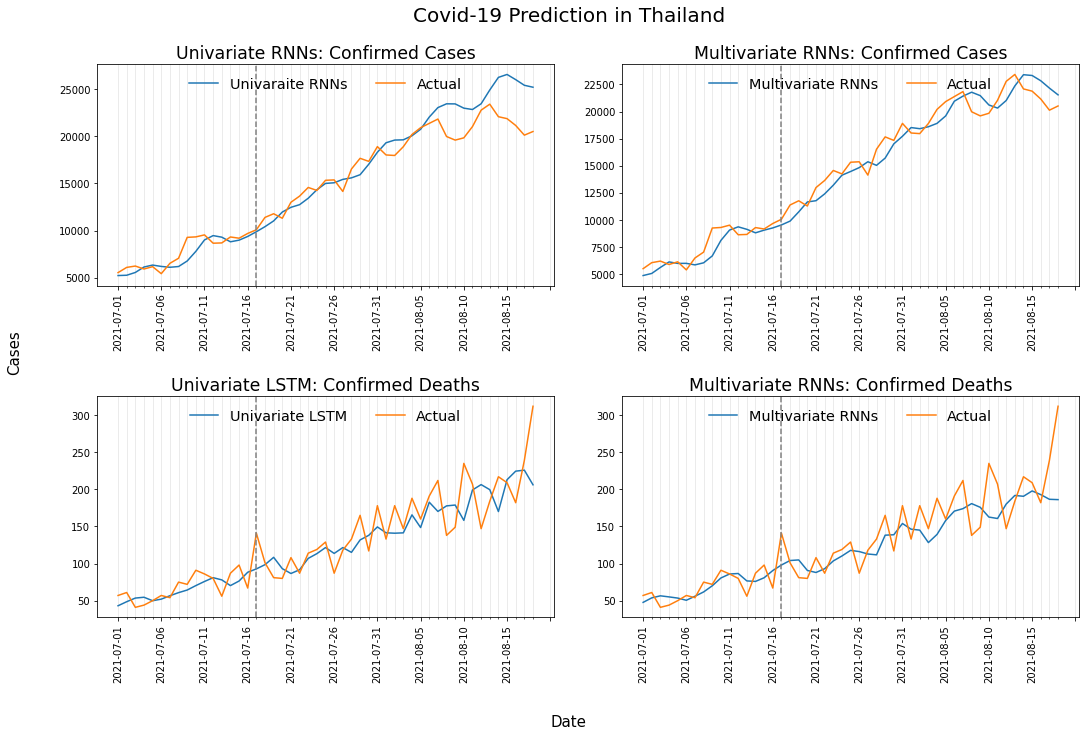

In [34]:
infect = pd.concat([y_uni_i_total, y_multi_i_total,
                   data.Cases_daily2.iloc[14:].reset_index(drop = True), 
                   data.Date.iloc[14:].reset_index(drop = True)],
                   axis=1)
infect.columns = ['uni_i', 'multi_i', 'actual', 'Date']

death = pd.concat([y_uni_d_total, y_multi_d_total,
                   data.Deaths_daily2.iloc[14:].reset_index(drop = True), 
                   data.Date.iloc[14:].reset_index(drop = True)],
                  axis=1)
death.columns = ['uni_d', 'multi_d', 'actual', 'Date']
tick_spacing = 5

fig, axes = plt.subplots(2, 2, figsize=(15,10)) 
fig.suptitle("Covid-19 Prediction in Thailand", fontsize=20)

# Univariate confirmed cases
axes[0, 0].plot(infect['Date'],infect['uni_i'], label = "Univaraite RNNs")
axes[0, 0].plot(infect['Date'],infect['actual'], label = "Actual")
axes[0, 0].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
axes[0, 0].set_title("Univariate RNNs: Confirmed Cases", fontsize = 'xx-large')
axes[0, 0].tick_params('x',labelrotation=90)
axes[0, 0].axvline("2021-07-17", color="gray", linestyle="--")
axes[0, 0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
axes[0, 0].xaxis.grid(True, which='both', alpha=0.3)
axes[0, 0].set_xticks(infect['Date'], minor=True)

# Multivariate confirmed cases
axes[0, 1].plot(infect['Date'],infect['multi_i'], label = "Multivariate RNNs")
axes[0, 1].plot(infect['Date'],infect['actual'], label = "Actual")
axes[0, 1].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
axes[0, 1].set_title("Multivariate RNNs: Confirmed Cases", fontsize = 'xx-large')
axes[0, 1].tick_params('x',labelrotation=90)
axes[0, 1].axvline("2021-07-17", color="gray", linestyle="--")
axes[0, 1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
axes[0, 1].set_xticks(infect['Date'], minor=True)
axes[0, 1].xaxis.grid(True, which='both', alpha=0.3)

# Univariate confirmed deaths
axes[1, 0].plot(death['Date'],death['uni_d'], label = "Univariate LSTM")
axes[1, 0].plot(death['Date'],death['actual'], label = "Actual")
axes[1, 0].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
axes[1, 0].set_title("Univariate LSTM: Confirmed Deaths", fontsize = 'xx-large')
axes[1, 0].tick_params('x',labelrotation=90)
axes[1, 0].axvline("2021-07-17", color="gray", linestyle="--")
axes[1, 0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
axes[1, 0].set_xticks(death['Date'], minor=True)
axes[1, 0].xaxis.grid(True, which='both', alpha=0.3)


# Multivariate confirmed deaths
axes[1, 1].plot(death['Date'],death['multi_d'], label = "Multivariate RNNs")
axes[1, 1].plot(death['Date'],death['actual'], label = "Actual")
axes[1, 1].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
axes[1, 1].set_title("Multivariate RNNs: Confirmed Deaths", fontsize = 'xx-large')
axes[1, 1].tick_params('x',labelrotation=90)
axes[1, 1].axvline("2021-07-17", color="gray", linestyle="--")
axes[1, 1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
axes[1, 1].set_xticks(death['Date'], minor=True)
axes[1, 1].xaxis.grid(True, which='both', alpha=0.3)



fig.text(0.5, -0.02, 'Date', ha='center', fontsize=15)
fig.text(-0.02, 0.5, 'Cases', va='center', rotation='vertical', fontsize=15)
fig.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.9)
plt.show()

### Result Table

In [35]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model Type', 'Best Model', 'Training', 'Test'],
                                           line_color = 'gray'),
                               cells=dict(values=[['Univariate: Confirmed Cases', 
                                                   'Univariate: Confirmed Deaths',
                                                   'Multivariate: Confirmed Cases',
                                                   'Multivariate: Confirmed Deaths'],
                                                  ['RNNs', 'LSTM', 'RNNs', 'RNNs'],
                                    [round(scores_uni_i1[1],3), round(scores_uni_d1[1],3),
                                     round(scores_multi_i1[1],3), round(scores_multi_d1[1],3)],
                                    [round(scores_uni_i[1],3), round(scores_uni_d[1],3),
                                     round(scores_multi_i[1],3), round(scores_multi_d[1],3)]],
                            align=['left','center', 'center', 'center'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Mean Absolute Percentage Error",title_x=0.5)
fig.show()

## Future Predictions

---



In [36]:
# Univariate
def future_prediction_uni(input, model, days_predicted, total_prediction):
  all_prediction = pd.DataFrame(total_prediction)

  # use the last 14 days from actual data
  all_input = input

  for i in range(1,days_predicted + 1):
    # create a matrix of input with 14 previous days
    new_input = np.array(all_input[-14:])
    new_input = new_input.reshape(1,14,1)

    # set seed
    seed(1)
    tensorflow.random.set_seed(1)

    # make the next day prediction
    last_output = model.predict(new_input)

    all_prediction = pd.concat([all_prediction, pd.DataFrame(last_output)], ignore_index=True)

    # feed the output back as new input
    all_input = pd.concat([all_input, pd.DataFrame(last_output)], ignore_index=True)
    all_input = pd.DataFrame(all_input)
  return all_prediction


In [37]:
# Multivariate
def future_prediction_multi(input, model, days_predicted, total_prediction):
  all_prediction = pd.DataFrame(total_prediction)

  # use the last 14 days from actual data
  all_input = input[-14:]

  for i in range(1,days_predicted + 1):
    # create a matrix of input with 14 previous days for all features
    new_input = np.expand_dims(all_input[-14:], axis = 0) 

    # set seed
    seed(1)
    tensorflow.random.set_seed(1)

    # make the next day prediction
    last_output = pd.DataFrame(model.predict(new_input))

    # record the prediction
    all_prediction = pd.concat([all_prediction, pd.DataFrame(last_output)], ignore_index=True)

    # new row
    new_row = [last_output[0], all_input.iloc[-1, 1:31], data_d.iloc[-14:, 31:49].mean(axis = 0)]
    new_row = list(itertools.chain(*new_row))

    # feed the new row back to data frame as new input
    all_input.loc[len(all_input)] = new_row
  return all_prediction

days_predicted = 15


### Univariate confirmed cases

In [38]:
days_predicted = 15

# univariate confirmed cases
uni_i_pred = future_prediction_uni(data.Cases_daily2, model_uni_i, days_predicted, y_uni_i_total)

# univariate confirmed deaths
uni_d_pred = future_prediction_uni(data.Deaths_daily2, model_uni_d, days_predicted, y_uni_d_total)

# multivariate confirmed cases
multi_i_pred = future_prediction_multi(data_i, model_multi_i, days_predicted, y_multi_i_total)

# multivariate confirmed deaths
multi_d_pred = future_prediction_multi(data_d, model_multi_d, days_predicted, y_multi_d_total)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Plots

In [39]:
# Date = pd.date_range('2021-07-01', periods=len(infect)+days_predicted, freq='D')
# Date = pd.DataFrame(Date)


# pred = pd.concat([Date.reset_index(drop = True), 
#                   uni_i_pred, 
#                   uni_d_pred],
#                  axis=1)
# pred.columns = ['Date', 'uni_i', 'uni_d']


# # extract actual data
# act = actual[502: 502 + len(Date)].reset_index(drop = True)


# tick_spacing = 5

# fig, axes = plt.subplots(2, 1, figsize=(20,10)) 
# fig.suptitle("Covid-19 Future Prediction in Thailand", fontsize=20)

# # Univariate confirmed cases
# axes[0].plot(pred['Date'], pred['uni_i'], label = "CNN")
# axes[0].plot(pred['Date'], act['Cases_daily'], label = "Actual")
# axes[0].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
# axes[0].set_title("Univariate CNN: Confirmed Cases", fontsize = 'xx-large')
# axes[0].tick_params('x',labelrotation=90)
# axes[0].axvline(dt.datetime(2021, 7, 29), color="gray", linestyle="--")
# axes[0].axvline(dt.datetime(2021, 8, 18), color="gray", linestyle="--")
# axes[0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
# axes[0].set_xticks(pred['Date'], minor=True)
# axes[0].xaxis.grid(True, which='both', alpha=0.3)

# # Univariate confirmed deaths
# axes[1].plot(pred['Date'],pred['uni_d'], label = "CNN")
# axes[1].plot(pred['Date'], act['Deaths_daily'], label = "Actual")
# axes[1].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
# axes[1].set_title("Univariate CNN: Confirmed Deaths", fontsize = 'xx-large')
# axes[1].tick_params('x',labelrotation=90)
# axes[1].axvline(dt.datetime(2021, 7, 29), color="gray", linestyle="--")
# axes[1].axvline(dt.datetime(2021, 8, 18), color="gray", linestyle="--")
# axes[1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
# axes[1].set_xticks(pred['Date'], minor=True)
# axes[1].xaxis.grid(True, which='both', alpha=0.3)



# fig.text(0.5, -0.02, 'Date', ha='center', fontsize=15)
# fig.text(-0.02, 0.5, 'Cases', va='center', rotation='vertical', fontsize=15)
# fig.tight_layout(pad=3.0)
# fig.subplots_adjust(top=0.9)
# plt.show()

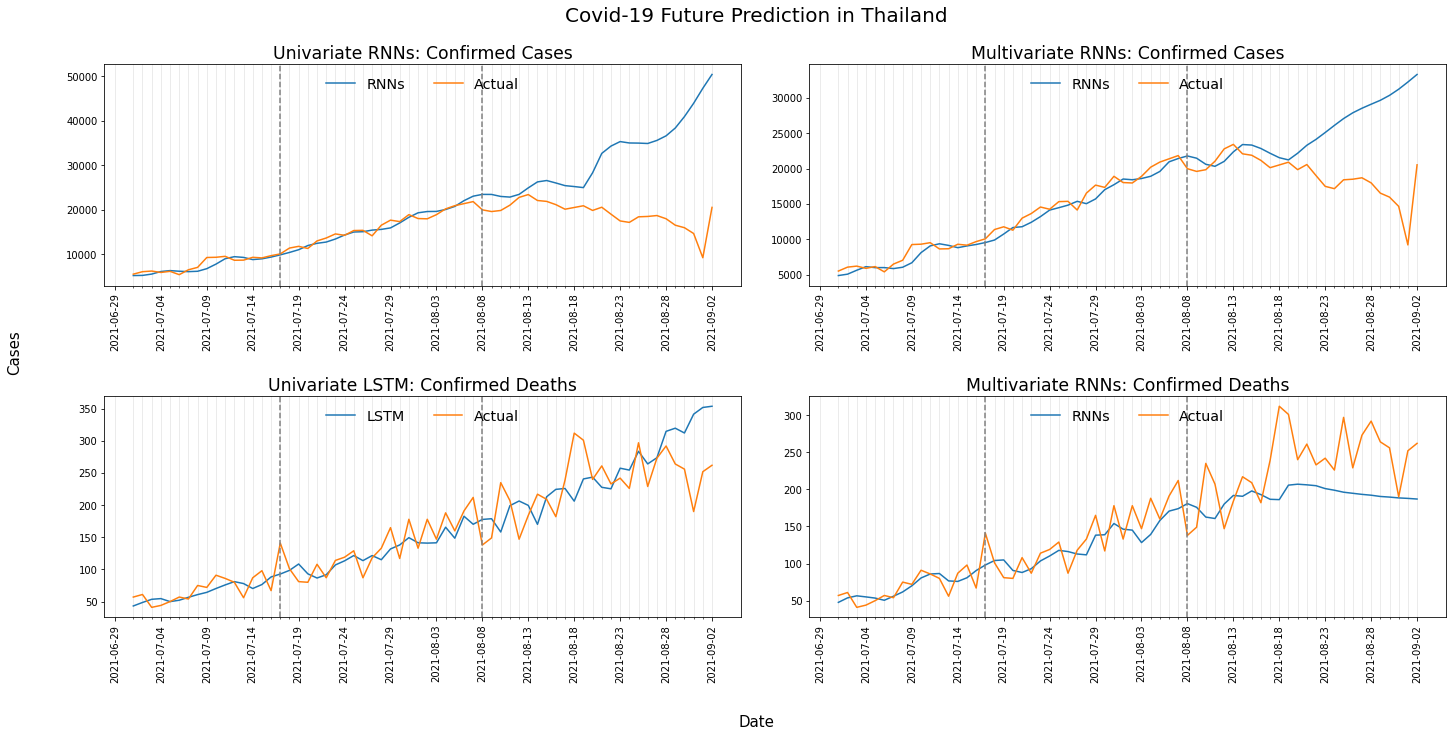

In [40]:
Date = pd.date_range('2021-07-01', periods=len(infect)+days_predicted, freq='D')
Date = pd.DataFrame(Date)


pred = pd.concat([Date.reset_index(drop = True), 
                  uni_i_pred, 
                  uni_d_pred,
                  multi_i_pred, 
                  multi_d_pred],
                 axis=1)
pred.columns = ['Date', 'uni_i', 'uni_d', 'multi_i', 'multi_d']


# extract actual data
act = actual[502: 502 + len(Date)].reset_index(drop = True)


tick_spacing = 5

fig, axes = plt.subplots(2, 2, figsize=(20,10)) 
fig.suptitle("Covid-19 Future Prediction in Thailand", fontsize=20)

# Univariate confirmed cases
axes[0,0].plot(pred['Date'], pred['uni_i'], label = "RNNs")
axes[0,0].plot(pred['Date'], act['Cases_daily'], label = "Actual")
axes[0,0].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
axes[0,0].set_title("Univariate RNNs: Confirmed Cases", fontsize = 'xx-large')
axes[0,0].tick_params('x',labelrotation=90)
axes[0,0].axvline(dt.datetime(2021, 7, 17), color="gray", linestyle="--")
axes[0,0].axvline(dt.datetime(2021, 8, 8), color="gray", linestyle="--")
axes[0,0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
axes[0,0].set_xticks(pred['Date'], minor=True)
axes[0,0].xaxis.grid(True, which='both', alpha=0.3)

# Multivariate confirmed cases
axes[0,1].plot(pred['Date'], pred['multi_i'], label = "RNNs")
axes[0,1].plot(pred['Date'], act['Cases_daily'], label = "Actual")
axes[0,1].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
axes[0,1].set_title("Multivariate RNNs: Confirmed Cases", fontsize = 'xx-large')
axes[0,1].tick_params('x',labelrotation=90)
axes[0,1].axvline(dt.datetime(2021, 7, 17), color="gray", linestyle="--")
axes[0,1].axvline(dt.datetime(2021, 8, 8), color="gray", linestyle="--")
axes[0,1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
axes[0,1].set_xticks(pred['Date'], minor=True)
axes[0,1].xaxis.grid(True, which='both', alpha=0.3)

# Univariate confirmed deaths
axes[1,0].plot(pred['Date'],pred['uni_d'], label = "LSTM")
axes[1,0].plot(pred['Date'], act['Deaths_daily'], label = "Actual")
axes[1,0].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
axes[1,0].set_title("Univariate LSTM: Confirmed Deaths", fontsize = 'xx-large')
axes[1,0].tick_params('x',labelrotation=90)
axes[1,0].axvline(dt.datetime(2021, 7, 17), color="gray", linestyle="--")
axes[1,0].axvline(dt.datetime(2021, 8, 8), color="gray", linestyle="--")
axes[1,0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
axes[1,0].set_xticks(pred['Date'], minor=True)
axes[1,0].xaxis.grid(True, which='both', alpha=0.3)


# Multivariate confirmed deaths
axes[1,1].plot(pred['Date'],pred['multi_d'], label = "RNNs")
axes[1,1].plot(pred['Date'], act['Deaths_daily'], label = "Actual")
axes[1,1].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
axes[1,1].set_title("Multivariate RNNs: Confirmed Deaths", fontsize = 'xx-large')
axes[1,1].tick_params('x',labelrotation=90)
axes[1,1].axvline(dt.datetime(2021, 7, 17), color="gray", linestyle="--")
axes[1,1].axvline(dt.datetime(2021, 8, 8), color="gray", linestyle="--")
axes[1,1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
axes[1,1].set_xticks(pred['Date'], minor=True)
axes[1,1].xaxis.grid(True, which='both', alpha=0.3)



fig.text(0.5, -0.02, 'Date', ha='center', fontsize=15)
fig.text(-0.02, 0.5, 'Cases', va='center', rotation='vertical', fontsize=15)
fig.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.9)
plt.show()